# **Aula Prática - Séries Temporais**

## Instalação de Bibliotecas

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot  #grafico de autocorrelacao
from pandas import DataFrame
from pandas import concat   #concatenar dataframes
import numpy as np
from math import sqrt   #raiz quadrada
import missingno as msno  #visualizacao de dados incompletos
import statsmodels.api as sm  #estimativa de modelos
from scipy.stats import boxcox  #transformacao de dados
import statsmodels.tsa.api as smt
from pmdarima import auto_arima   #descobre melhor modelo ARIMA

from sklearn.metrics import mean_squared_error  #metrica do erro quadratico medio
from statsmodels.tsa.seasonal import seasonal_decompose   #decomposicao da serie temporal
from statsmodels.tsa.stattools import adfuller  #teste de estacionariedade
from statsmodels.tsa.stattools import acf   #autocorrelacao
from statsmodels.tsa.stattools import pacf  #autocorrelacao parcial
from statsmodels.tsa.arima_model import ARIMA   #modelo de previsao

#configuracao de plotagem dos graficos
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## Leitura da Base de Dados e Visualização

In [ ]:
#leitura do csv
df = pd.read_csv("AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
#definicao de parametros pra plotagem
rcParams['figure.figsize']= 10, 7

In [ ]:
#checando os dados
def check_data(df):
    print('DIMENSION: ({}, {})'.format(df.shape[0], df.shape[1]))
    print("COLUMNS:\n")
    print(df.columns.values)
    print("DATA INFO:\n")
    print(df.dtypes)
    print("MISSING VALUES:\n")
    print(df.isnull().sum())
    print("NUMBER OF UNIQUE VALUES:\n")
    print(df.nunique())

In [ ]:
check_data(df)

DIMENSION: (144, 2)
COLUMNS:

['Month' '#Passengers']
DATA INFO:

Month          object
#Passengers     int64
dtype: object
MISSING VALUES:

Month          0
#Passengers    0
dtype: int64
NUMBER OF UNIQUE VALUES:

Month          144
#Passengers    118
dtype: int64


In [ ]:
#renomeando e reindexando
df['Date'] = pd.to_datetime(df['Month'])
df = df.drop(columns='Month')
df = df.set_index('Date')
df = df.rename(columns={'#Passengers':'Passengers'})

In [ ]:
#visualização
df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
#criando funcao de plotagem da serie
def plot_ts(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

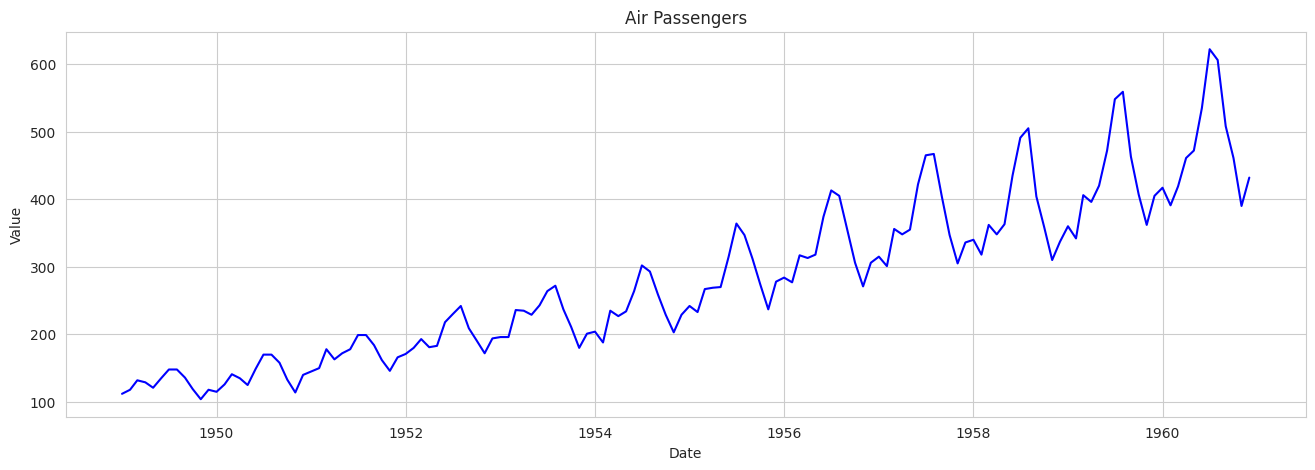

In [ ]:
plot_ts(df, x=df.index, y=df["Passengers"], title="Air Passengers")

## Decomposição

Utilizar métodos de decomposição, como a decomposição clássica (por exemplo, decomposição aditiva ou multiplicativa) ou decomposição STL (Seasonal and Trend decomposition using Loess), disponíveis em bibliotecas como statsmodels ou seasonal_decompose do pacote statsmodels.tsa, para separar os componentes principais da série (tendência, sazonalidade e componente de erro).

**Quando usar o modelo aditivo ou o modelo multiplicativo?**

*   **Modelo multiplicativo:** quando as variações em torno da tendência estão relacionadas ao nível da série temporal. Isso significa que as mudanças percentuais (ou proporcionais) na série são constantes em cada período do ciclo

*   Y[t] = Tendência[t] * Sazonalidade[t] * Ciclo[t] * Erro[t]

*   o resíduo (ou erro) representa a razão entre o valor observado e o valor previsto pela tendência e pelos componentes sazonais e cíclicos





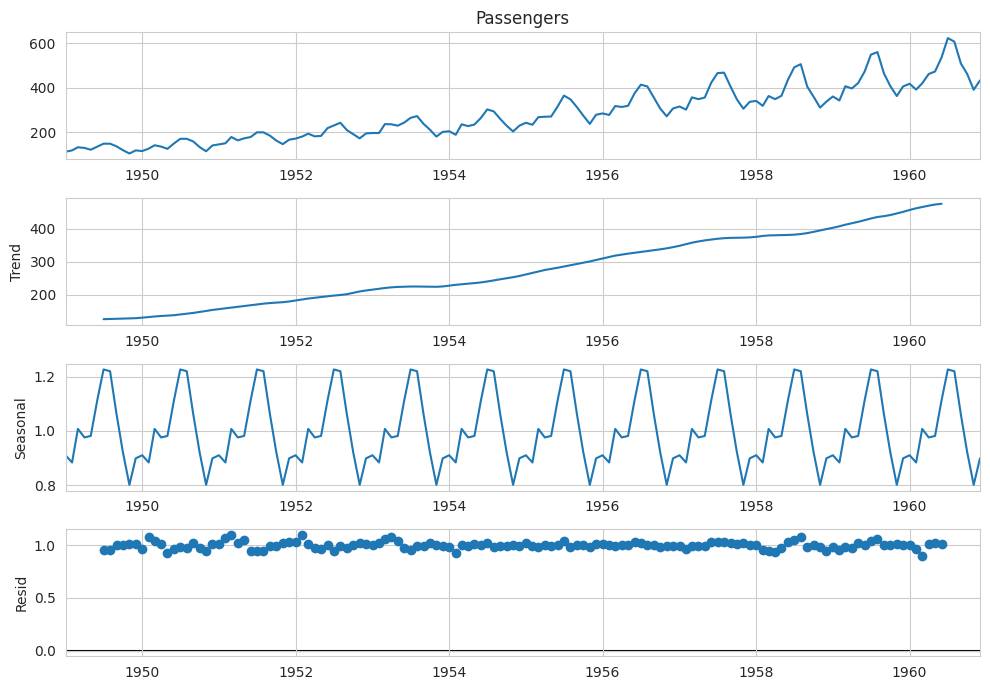

In [ ]:
dec = sm.tsa.seasonal_decompose(df['Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

*  **Modelo aditivo:** quando as variações em torno da tendência são constantes em termos absolutos, independentemente do nível da série temporal. Isso significa que as mudanças absolutas na série são constantes em cada período do ciclo
*  Y[t] = Tendência[t] + Sazonalidade[t] + Ciclo[t] + Erro[t]
*  o resíduo (ou erro) representa a diferença entre o valor observado e o valor previsto pela tendência e pelos componentes sazonais e cíclicos

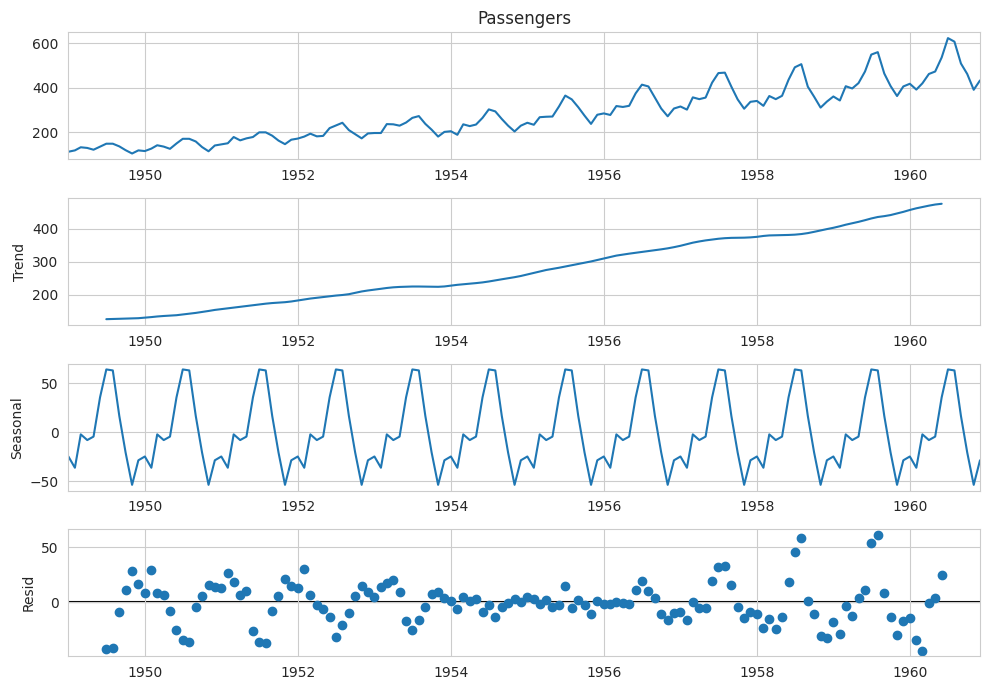

In [ ]:
dec = sm.tsa.seasonal_decompose(df['Passengers'],period = 12, model = 'additive').plot()
plt.show()

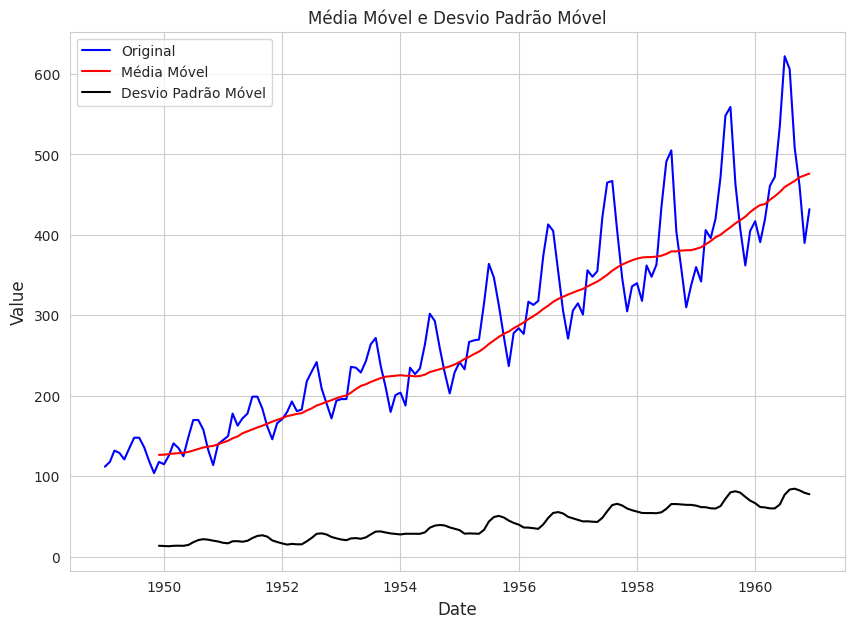

In [ ]:
# calculando e plotando o valor original da serie, juntamente com sua media móvel e desvio padreo móvel
def rolling_stats(df):
    rolling_mean = df.rolling(window = 12).mean()
    rolling_std = df.rolling(window = 12).std()
    plt.plot(df, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Média Móvel')
    plt.plot(rolling_std, color = 'black', label = 'Desvio Padrão Móvel')
    plt.xlabel('Date', size = 12)
    plt.ylabel('Value', size  = 12)
    plt.legend(loc = 'best')
    plt.title('Média Móvel e Desvio Padrão Móvel')
    plt.show()

rolling_stats(df)


## Estacionariedade e Testes

 Uma série temporal é considerada estacionária se satisfizer as seguintes condições:

*   **Média constante:** A média da série não deve ser uma
função do tempo.
*   **Variância constante:** A variância da série também não deve variar em função do tempo, essa característica é chamada de homocedasticidade.

*   **Autocorrelação independente do tempo:** A covariância dos termos i-ésimo e (i+m)-ésimo não deve ser uma função dependente do tempo. A correlação entre dois pontos em uma série temporal é a mesma, independente do período em que estejam localizados.

 Realizar testes de estacionariedade, como o Teste de Dickey-Fuller Aumentado (ADF) ou o Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin), usando bibliotecas como statsmodels.tsa.stattools para verificar se a série é estacionária. Se a série não for estacionária, pode ser necessário aplicar técnicas de diferenciação para torná-la estacionária.


In [ ]:
def adf_test(df):
    result = adfuller(df.values, autolag='AIC')
    print('ADF Statistic: {}'.format(round(result[0], 3)))
    print(40*"*")
    print('p-value: {}'.format(round(result[1], 3)))
    print(40*"*")
    for key, value in result[4].items():
        print('Critial Values:')
        print('{}: {}'.format(key, round(value, 3)))

adf_test(df)

ADF Statistic: 0.815
****************************************
p-value: 0.992
****************************************
Critial Values:
1%: -3.482
Critial Values:
5%: -2.884
Critial Values:
10%: -2.579


***Interpretações:***

1.  **ADF < valor crítico e p-valor < nível de significância (padrão 0,05) :** rejeita-se a hipótese nula de que a série possui raiz unitária e considera-se que a série é estacionária
2.    **ADF > valor crítico e e p-valor > nível de significância (padrão 0,05) :** não se rejeita a hipótese nula de que a série possui raiz unitária e considera-se que a série não é estacionária.
3.    **ADF ~ valor crítico e p-valor ~ nível de significância (padrão 0,05) :**  a série pode ser considerada marginalmente estacionária ou a decisão pode ser inconclusiva. Serão necessários outros testes;


## Transformação da Série

**Box-Cox:**
 Técnica de transformação de dados  utilizada para estabilizar a variância, tornar os dados mais semelhantes à distribuição normal, melhorar a validade das medidas de associação (como a correlação de Pearson entre as variáveis).

In [ ]:
# Transformação de Box-Cox
df_log = df.copy()
df_log['Passengers'] = boxcox(df_log['Passengers'], lmbda=0.0)

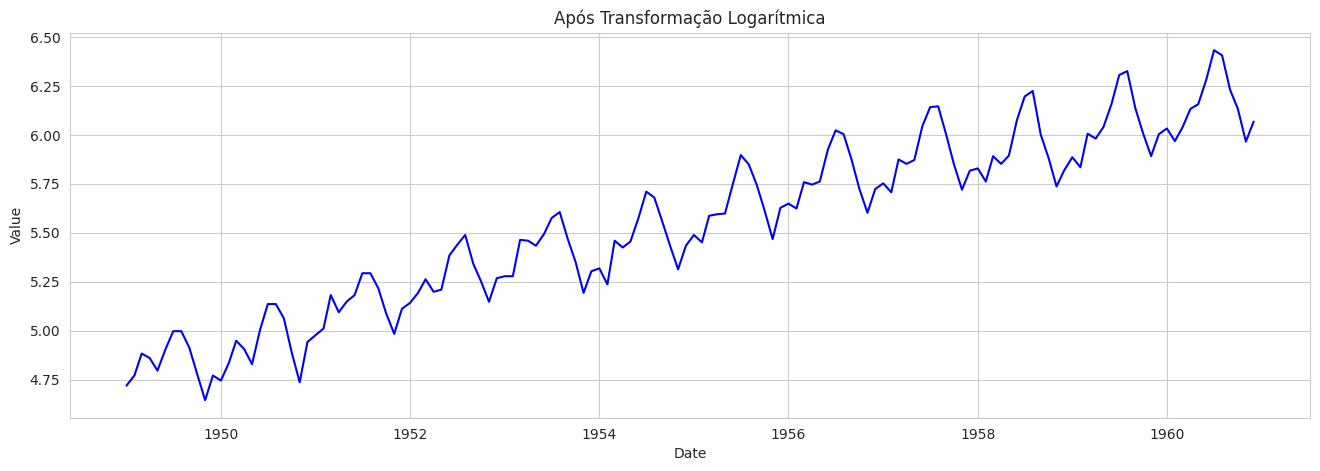

In [ ]:
plot_ts(df_log, x=df_log.index, y=df_log["Passengers"], title="Após Transformação Logarítmica")

In [ ]:
#refazendo o teste de estacionariedade
adf_test(df_log)

ADF Statistic: -1.717
****************************************
p-value: 0.422
****************************************
Critial Values:
1%: -3.482
Critial Values:
5%: -2.884
Critial Values:
10%: -2.579


In [ ]:
# Removendo tendência com a media movel
moving_avg = df_log.rolling(window=12).mean()
df_log_ma = df_log - moving_avg
df_log_ma.dropna(inplace=True)

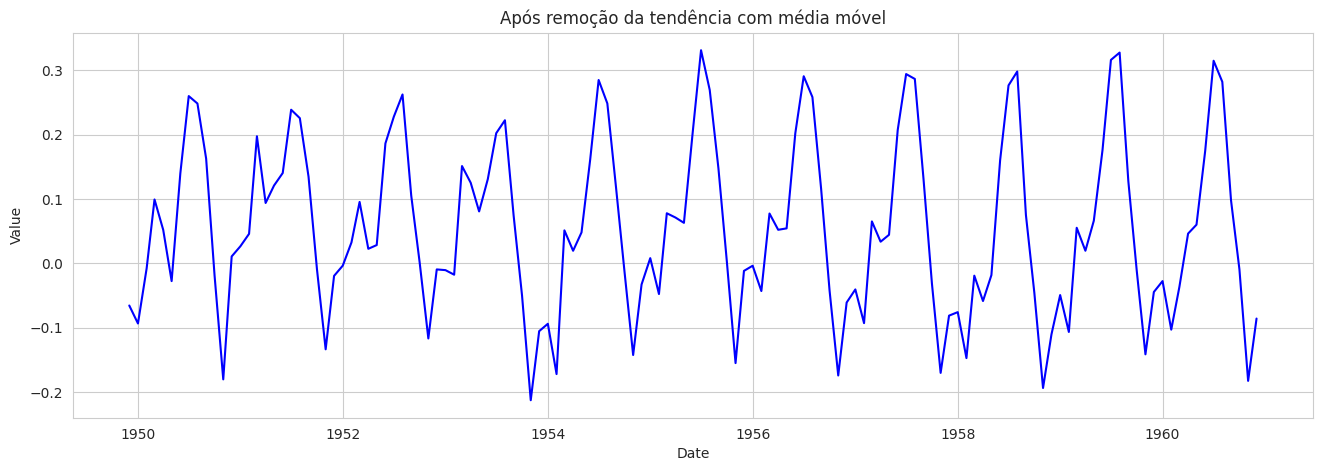

In [ ]:
plot_ts(df_log_ma, x=df_log_ma.index, y=df_log_ma["Passengers"], title="Após remoção da tendência com média móvel")

In [ ]:
adf_test(df_log_ma)

ADF Statistic: -3.163
****************************************
p-value: 0.022
****************************************
Critial Values:
1%: -3.487
Critial Values:
5%: -2.886
Critial Values:
10%: -2.58


In [ ]:
#fazendo a media exponencialmente ponderada para ajuste
df_log_ma_ed = df_log_ma.ewm(halflife=12, min_periods=0, adjust=True).mean()
#calculando diferença com a série ma
df_lsma_sub_df_lsma_ed = df_log_ma - df_log_ma_ed

In [ ]:
adf_test(df_lsma_sub_df_lsma_ed)

ADF Statistic: -3.25
****************************************
p-value: 0.017
****************************************
Critial Values:
1%: -3.487
Critial Values:
5%: -2.886
Critial Values:
10%: -2.58


## Autocorrelação

*   **ACF - Autocorrelation Function:**
é a correlação de uma série temporal com uma cópia defasada de si mesma. A ACF é usada principalmente para identificar a estrutura de MA (Moving Average) em um modelo ARIMA.

*   **PACF - Partial Autocorrelation Function:** mede a correlação entre um ponto e seus predecessores, descontando a autocorrelação entre esses pontos. A PACF será usada para identificar a estrutura de AR (Auto Regressive) em um modelo ARIMA.

In [ ]:
#plotando série temporal estacionária e calculando correlações
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Análise da Série Temporal\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

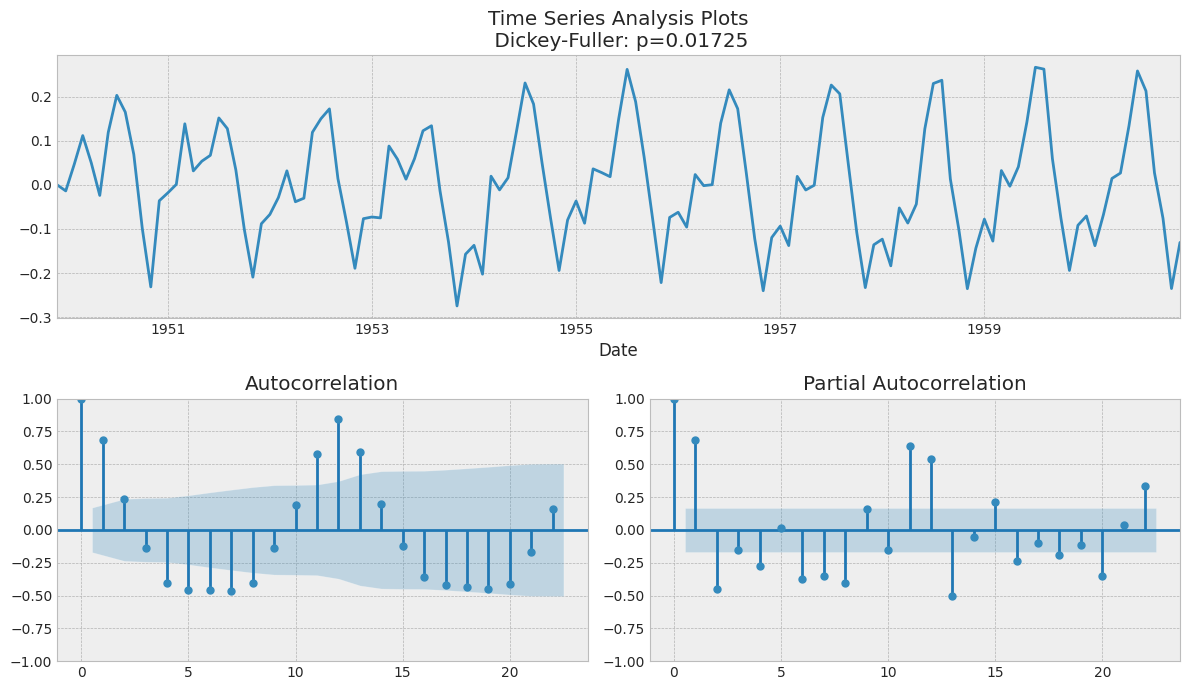

In [ ]:
tsplot(df_lsma_sub_df_lsma_ed['Passengers'])

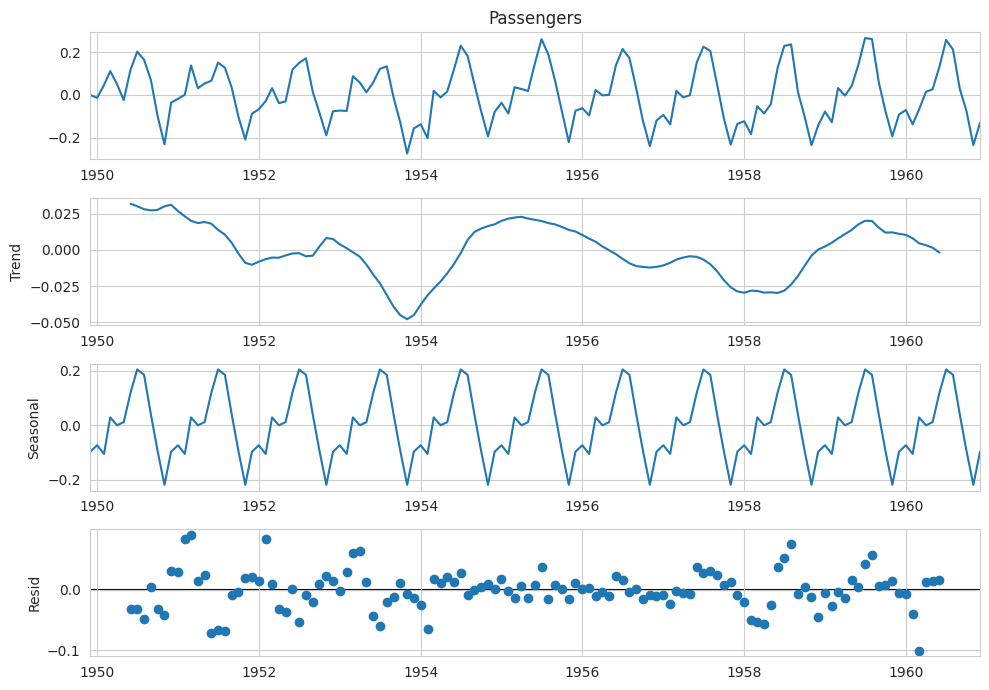

In [ ]:
#decomposição da série original e componentes
dec = sm.tsa.seasonal_decompose(df_lsma_sub_df_lsma_ed['Passengers'],period = 12, model = 'additive').plot()
plt.show()

## Modelagem e Previsão

**ARIMA** significa **Média Móvel Integrada Auto-Regressiva**, e é uma classe de modelo que explora a correlação em dados de séries temporais para prever melhor os pontos futuros.

Um modelo ARIMA possui **três parâmetros: (p, d, q)**
*   **p:** é o número de termos auto-regressivos (AR). Lida com a autocorrelação entre um valor atual e seus valores anteriores.
*   **d:** é a ordem da diferenciação (Differencing). Esta parte do modelo é responsável por tornar a série temporal estacionária.
*   **q:** é o número de erros de previsão passados na equação de previsão, também conhecido como ordem de média móvel (MA).

In [ ]:
#divisão do dataset em treinamento e teste
length = 115
train = df_lsma_sub_df_lsma_ed[:length]
test = df_lsma_sub_df_lsma_ed[length:]

In [ ]:
model_auto_arima = auto_arima(train, start_p=1, start_q=1, d=1,
                              max_p=12, max_q=12, max_d=6, D=1, start_P=1, start_Q=1,max_D=6,
                               max_P=6, max_Q=6, m=12, seasonal=True,
                              error_action='warn', suppress_warnings=True, random_state=100)
model_auto_arima

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
model_arima = sm.tsa.arima.ARIMA(train, order=(1,1,0), seasonal_order=(0,1,1,12))
model_fit_arima = model_arima.fit()
model_fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  115
Model:             ARIMA(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 195.749
Date:                            Tue, 18 Jul 2023   AIC                           -385.497
Time:                                    18:17:25   BIC                           -377.623
Sample:                                12-01-1949   HQIC                          -382.309
                                     - 06-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3382      0.074     -4.596      0.000      -0.482      -0.194
ma.S.L12      -0.5076      0.094     -5.381      0.000      -0.693      -0.323
sigma2         0.0012      0.000      6.682      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.99   Prob(JB):                         0.97
Heteroskedasticity (H):               0.36   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

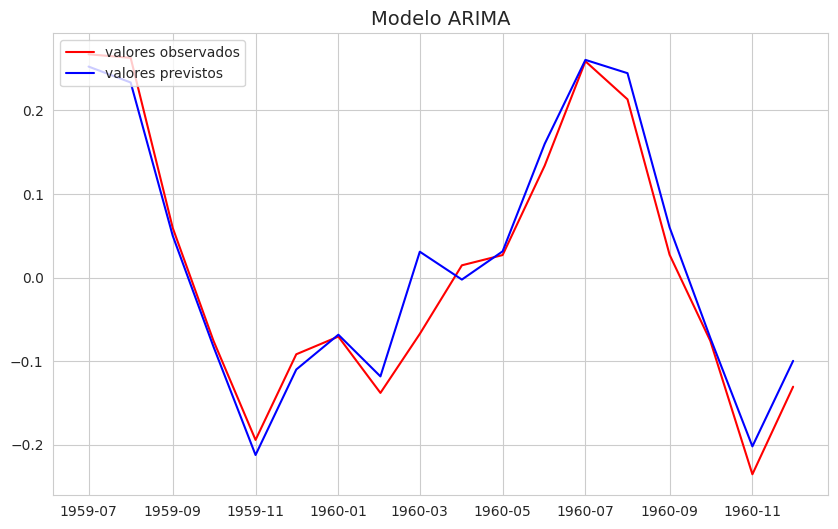

In [ ]:
predictions = model_fit_arima.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

plt.figure(figsize = (10,6))
plt.plot(test, label = "valores observados", color = "red")
plt.plot(predictions,label = "valores previstos", color='blue')
plt.title("Modelo ARIMA", size = 14)
plt.legend(loc = 'upper left')
plt.show()